# Save results in cloud object store

In this demo we will show you how to remotely process data on the EODC cluster
using dask and save the result in a cloud object store. In a final step, we will
read parts of the result back and plot it directly on our local machine. Here, we will use our object
storage based on CEPH. Please see
[here](https://docs.eodc.eu/services/objectstore.html) for more
information. 
Furthermore, this demo is partly based on the [EODC Dask
Tutorial](https://docs.eodc.eu/tutorials/gfm_maximum_flood_extent_dask.html).

As an example, we will calculate the maximum flood extent as well as the mean of
the GFM likelihood values for a certain time range over an area of interest in
Pakistan. 

## Prerequisites

Before we start, make sure you have installed all the necessary Python libraries and
packages with the correct versions. It is important that the cluster and client
(your machine) have the same versions for the key Python libraries. The easiest
way is to create a new Python environment with the package manager of your liking.
See the required dependencies in the [EODC cluster image](https://github.com/eodcgmbh/cluster_image) repository.

In order to spin up a dedicated cluster on the EODC cluster, you will need to
request an EODC account. Please follow the instructions [here](https://docs.eodc.eu/services/dask.html#who-should-use-dask-gateway-at-eodc).

## First some imports

In [ ]:
import s3fs
import pyproj
import rioxarray
import xarray as xr
from datetime import datetime
from shapely.geometry import box
from pystac_client import Client
from odc import stac as odc_stac
import matplotlib.pyplot as plt

from eodc import settings
from eodc.dask import EODCDaskGateway

settings.DASK_URL = "http://dask.services.eodc.eu"
settings.DASK_URL_TCP = "tcp://dask.services.eodc.eu:80/"

## Initialize cluster

Your username of your EODC account come here, usually it is your email address
you have used for registration. 
After running the next cell, a prompt will open and ask you to enter your
password. 

In [ ]:
your_username = "your.email@address.com"
gateway = EODCDaskGateway(username=your_username)

Once authenticated, you can specify the details of your cluster. 

A new cluster will be created. Use the URL, which is printed after running the
next cell to get an overview what is currently happening on your cluster. 

In [ ]:
# Define cluster options
cluster_options = gateway.cluster_options()

# Set the number of cores per worker
cluster_options.worker_cores = 8

# Set the memory per worker (in GB)
cluster_options.worker_memory = 16

# Specify the Docker image to use for the workers
cluster_options.image = "ghcr.io/eodcgmbh/cluster_image:2025.2.0"

# Create a new cluster with the specified options
cluster = gateway.new_cluster(cluster_options)

# Automatically scale the cluster between 1 and 10 workers based on workload
cluster.adapt(1, 10)  

# Optionally, scale the cluster to use only one worker
# cluster.scale(1)

# Get a Dask client for the cluster
client = cluster.get_client()
client.dashboard_link

## Search and load data

Now we will define our area (AOI) and time range of interest for which we want
to calculate the maximum flood extent as well as the mean of the likelihood.

In [17]:
# Define the API URL
api_url = "https://stac.eodc.eu/api/v1"

# Define the STAC collection ID
collection_id = "GFM"

# Define the area of interest (AOI) as a bounding box
aoi = box(67.398376, 26.197341, 69.027100, 27.591066)

# Define the time range for the search
time_range = (datetime(2022, 9, 1), datetime(2022, 10, 1))

# Open the STAC catalog using the specified API URL
eodc_catalog = Client.open(api_url)

# Perform a search in the catalog with the specified parameters
search = eodc_catalog.search(
    max_items=1000,             # Maximum number of items to return
    collections=collection_id,  # The collection to search within
    intersects=aoi,             # The area of interest
    datetime=time_range         # The time range for the search
)

# Collect the found items into an item collection
items = search.item_collection()

print(f"On EODC we found {len(items)} items for the given search query")

On EODC we found 157 items for the given search query


The data will be lazy-loaded into a xarray.Dataset object.

In [ ]:
# Extract the coordinate reference system (CRS) from the first item's properties
crs = pyproj.CRS.from_wkt(items[0].properties["proj:wkt2"])

# Set the resolution of the data
resolution = items[0].properties['gsd']

# Specify the bands to load
bands = ["ensemble_flood_extent", "ensemble_likelihood"]

# Load the data using odc-stac with the specified parameters
xx = odc_stac.load(
    items, 
    bbox=aoi.bounds,   # Define the bounding box for the area of interest
    crs=crs,   # Set the coordinate reference system
    bands=bands,   # Specify the bands to load
    resolution=resolution,   # Set the resolution of the data
    dtype='uint8',   # Define the data type
    chunks={"x": 1000, "y": 1000, "time": -1},  # Set the chunk size for Dask
)

Create a ZARR store object by specifying the endpoint_url, bucket_name and
credentials of your object storage (e.g. EODC object store, AWS S3). 

In [ ]:
# Specify the endpoint_url of your object storage
endpoint_url = '<endpoint_url>'

# Specify the name of your S3 bucket
s3_bucket = '<bucket_name>'

# Specify the credentials for accessing your S3 bucket
key = '<key>'
secret = '<secret>'

# Create a S3FileSystem object
s3fs_central = s3fs.S3FileSystem(
    key=key,
    secret=secret,
    client_kwargs={'endpoint_url': endpoint_url},
)

# Specify the filename of your output ZARR file
path = f'{s3_bucket}/gfm_flood_likelihood_pakistan_202209.zarr'

# Create the ZARR store object
zarr_store = s3fs.S3Map(root=path, s3=s3fs_central, check=False)

## Process on the cluster

For each of the data variables, we will define an own "process graph". The
maximum flood extent refers to the largest area covered by flooded pixels during
the specified time range. For the ensemble likelihood, we will calculate the
mean values. 

As a final step, we will trigger the computation on the Dask cluster and save
directly the result to the specified ZARR store on our cloud object storage.

In [ ]:
results = {}

# ensemble_flood_extent
var = 'ensemble_flood_extent'
flood_extent = xx[var].where((xx[var] != 255) & (xx[var] != 0)).sum(dim="time")
results[var] = xr.where(flood_extent > 0, 1, 0).astype("uint8")

# ensemble_likelihood
var = 'ensemble_likelihood'
results[var] = xx[var].where((xx[var] != 255) & (xx[var] != 0)).mean(dim="time").astype("uint8")

# Combine the results into a new dataset
result_dataset = xr.Dataset(results)

# Trigger computation and save the result directly to the specified ZARR store
result_dataset.compute(sync=True).to_zarr(store=zarr_store, mode="w")

## Shutdown cluster

After successful computation we can shutdown the cluster

In [ ]:
cluster.close(shutdown=True)

## Visualize results

To demonstrate that we do not need to download the whole file, we will only plot
parts of one calculated data variable (mean of ensemble likelihood).

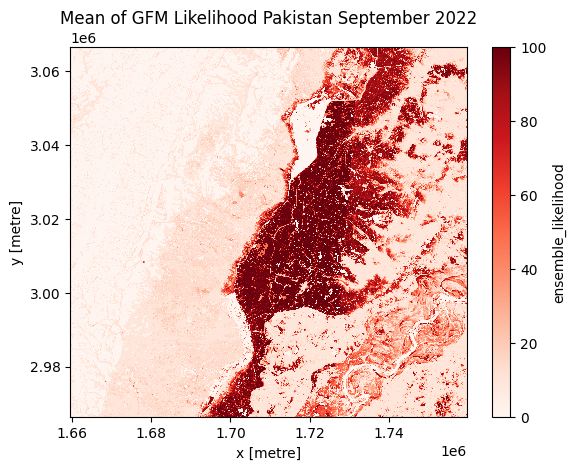

In [19]:
# Lazy-load the ZARR store with xarray
ds = xr.open_zarr(store=zarr_store)

# Plot parts of mean of ensemble likelihood
plt.figure()
ds.ensemble_likelihood[:5000, :5000].plot(cmap="Reds")
plt.title("Mean of GFM Likelihood Pakistan September 2022")
plt.show()